Imports Libraries



In [60]:
!pip install tensorboard

     |████████████████████████████████| 5.8 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 21.9 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 93 kB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 232 kB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 123 kB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 162 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 167 kB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 151 kB 2.1 MB/s eta 0:00:01
  Created wheel for grpcio: filename=grpcio-1.47.0-cp39-cp39-macosx_11_0_arm64.whl size=3207139 sha256=fca1b3ce6c1694f7b3250aeb5d97034ebb2c74f0450b69fe638b2aca99050f0c
  Stored in directory: /Users/esteban/Library/Caches/pip/wheels/f3/90/8f/66b83f36a381

In [46]:
# Gym stuff
import gym
from gym import spaces
from gym.utils import seeding
import gym_anytrading
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from stable_baselines3 import DQN
#from stable_baselines3 import ACER
import stable_baselines3

from stable_baselines3.dqn.policies import MlpPolicy 
from stable_baselines3.dqn.policies import DQNPolicy

# Processing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from enum import Enum
import statistics
import os


Creates trading environment

In [64]:


class Actions(Enum):
    Sell = 0
    Buy = 1
    Hold = 2


class Positions(Enum):
    Short = 0
    Long = 1
    Hold = 2

    def opposite(self):
        if self == Positions.Hold:
           return Positions.Hold
        elif self == Positions.Long: 
          return Positions.Short 
        else:
          return Positions.Long


class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}

    def __init__(self, df, window_size):
        assert df.ndim == 2

        self.seed()
        self.df = df
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = spaces.Discrete(len(Actions))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float32)

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._done = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None


    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


    def reset(self):
        self._done = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Short
        self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 100.  # unit
        self._first_rendering = True
        self.history = {}
        return self._get_observation()


    def step(self, action):
        self._done = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._done = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        self._update_profit(action)

        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or 
            (action == Actions.Sell.value and self._position == Positions.Long) or 
            (action == Actions.Hold.value and self._position == Positions.Hold)):
            trade = True

        if trade:
            self._position = self._position.opposite()
            self._last_trade_tick = self._current_tick

        self._position_history.append(self._position)
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)

        return observation, step_reward, self._done, info


    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size):self._current_tick]


    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)


    def render(self, mode='human'):

        def _plot_position(position, tick):
            color = None
            if position == Positions.Short:
                color = 'red'
            elif position == Positions.Long:
                color = 'green'
            if color:
                plt.scatter(tick, self.prices[tick], color=color)

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.prices)
            start_position = self._position_history[self._start_tick]
            _plot_position(start_position, self._start_tick)

        _plot_position(self._position, self._current_tick)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

        plt.pause(0.01)


    def render_all(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)

        plt.plot(short_ticks, self.prices[short_ticks], 'ro')
        plt.plot(long_ticks, self.prices[long_ticks], 'go')

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        
        
    def close(self):
        plt.close()


    def save_rendering(self, filepath):
        plt.savefig(filepath)


    def pause_rendering(self):
        plt.show()


    def _process_data(self):
        raise NotImplementedError


    def _calculate_reward(self, action):
        raise NotImplementedError


    def _update_profit(self, action):
        raise NotImplementedError


    def max_possible_profit(self):  # trade fees are ignored
        raise NotImplementedError




class BinaryEnv(TradingEnv):

    def __init__(self, df, window_size, frame_bound, unit_side='left'):
        assert len(frame_bound) == 2
        assert unit_side.lower() in ['left', 'right']

        self.frame_bound = frame_bound
        self.unit_side = unit_side.lower()
        super().__init__(df, window_size)

        self.trade_fee = 0.0003  # unit


    def _process_data(self):
        prices = self.df.loc[:, 'Close'].to_numpy()

        prices[self.frame_bound[0] - self.window_size]  # validate index (TODO: Improve validation)
        prices = prices[self.frame_bound[0]-self.window_size:self.frame_bound[1]]

        diff = np.insert(np.diff(prices), 0, 0)
        signal_features = np.column_stack((prices, diff))

        return prices, signal_features


    def _calculate_reward(self, action):
        step_reward = 0  # pip

        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            price_diff = current_price - last_trade_price

            if self._position == Positions.Short:
                  step_reward += 2
            elif self._position == Positions.Long:
                  step_reward += 2


        return step_reward


    def _update_profit(self, action):
        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade or self._done:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self.unit_side == 'left':
                if self._position == Positions.Short:
                    quantity = self._total_profit * (last_trade_price - self.trade_fee)
                    self._total_profit = quantity / current_price

            elif self.unit_side == 'right':
                if self._position == Positions.Long:
                    quantity = self._total_profit / last_trade_price
                    self._total_profit = quantity * (current_price - self.trade_fee)


    def max_possible_profit(self):
        current_tick = self._start_tick
        last_trade_tick = current_tick - 1
        profit = 1.

        while current_tick <= self._end_tick:
            position = None
            if self.prices[current_tick] < self.prices[current_tick - 1]:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] < self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Short
            else:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] >= self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Long

            current_price = self.prices[current_tick - 1]
            last_trade_price = self.prices[last_trade_tick]

            if self.unit_side == 'left':
                if position == Positions.Short:
                    quantity = profit * (last_trade_price - self.trade_fee)
                    profit = quantity / current_price

            elif self.unit_side == 'right':
                if position == Positions.Long:
                    quantity = profit / last_trade_price
                    profit = quantity * (current_price - self.trade_fee)

            last_trade_tick = current_tick - 1

        return profit

Imports Data Frame

In [12]:
with open("BTCUSD_1day.pickle", \
          "rb") as f:
      df \
      = pickle.load(f)

df

,Symbol,Open,High,Low,Close,Volume,sma7,sma25,sma99,bb_bbm,bb_bbh,bb_bbl,psar,MACD,RSI,sma40,OBV
Date,,,,,,,,,,,,,,,,,
2015-10-08,BTCUSD,242.50,245.00,242.50,243.95,18.80,242.500000,242.500000,242.500000,0.0000,0.000000,0.000000,243.950000,0.000000,100.000000,0.00000,0.00
2015-10-09,BTCUSD,243.95,249.97,243.60,245.39,30.99,243.225000,243.225000,243.225000,0.0000,0.000000,0.000000,245.390000,0.114872,100.000000,0.00000,30.99
2015-10-10,BTCUSD,245.39,246.30,244.60,246.30,12.17,243.946667,243.946667,243.946667,0.0000,0.000000,0.000000,243.950000,0.276155,100.000000,0.00000,43.16
2015-10-11,BTCUSD,246.30,249.50,246.30,249.50,12.22,244.535000,244.535000,244.535000,0.0000,0.000000,0.000000,244.600000,0.654639,100.000000,0.00000,55.38
2015-10-12,BTCUSD,249.50,249.50,247.60,247.60,38.28,245.528000,245.528000,245.528000,0.0000,0.000000,0.000000,244.600000,0.792146,72.095821,0.00000,17.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-06,BTCUSD,6775.21,7369.76,6771.01,7336.96,3727.47,6669.842857,6125.836000,8160.088182,6355.7180,7229.164087,5482.271913,5330.828725,-77.430673,57.402004,7009.73250,402187.43
2020-04-07,BTCUSD,7336.96,7468.42,7078.00,7201.81,2333.34,6802.707143,6226.096400,8159.548182,6455.4125,7298.400087,5612.424913,5531.441853,-32.150404,55.331042,6969.53125,399854.09
2020-04-08,BTCUSD,7201.81,7432.23,7152.80,7369.60,2483.60,6913.174286,6288.047600,8159.402121,6544.4805,7303.485116,5785.475884,5711.993667,17.076934,57.386583,6936.14925,402337.69


In [66]:

lower_limit = 50
upper_limit = 1800

env_random = BinaryEnv(df=df, frame_bound=(lower_limit,upper_limit), window_size=5)


info {'total_reward': 1056.0, 'total_profit': 6.077425094809681, 'position': 0}
info {'total_reward': 1048.0, 'total_profit': 45.93354355605816, 'position': 0}
info {'total_reward': 1114.0, 'total_profit': 77.33316669841933, 'position': 1}
info {'total_reward': 1048.0, 'total_profit': 15.963975896083687, 'position': 0}
info {'total_reward': 1050.0, 'total_profit': 38.965872157956504, 'position': 1}
info {'total_reward': 1014.0, 'total_profit': 135.98498302027846, 'position': 1}
info {'total_reward': 1110.0, 'total_profit': 20.861610084323278, 'position': 1}
info {'total_reward': 1072.0, 'total_profit': 19.750479719774262, 'position': 0}
info {'total_reward': 1084.0, 'total_profit': 64.06785383093798, 'position': 0}
info {'total_reward': 1160.0, 'total_profit': 16.0735104414383, 'position': 0}
info {'total_reward': 1126.0, 'total_profit': 10.048484881457382, 'position': 1}
info {'total_reward': 1116.0, 'total_profit': 5.938632139420456, 'position': 0}
info {'total_reward': 1070.0, 'tota

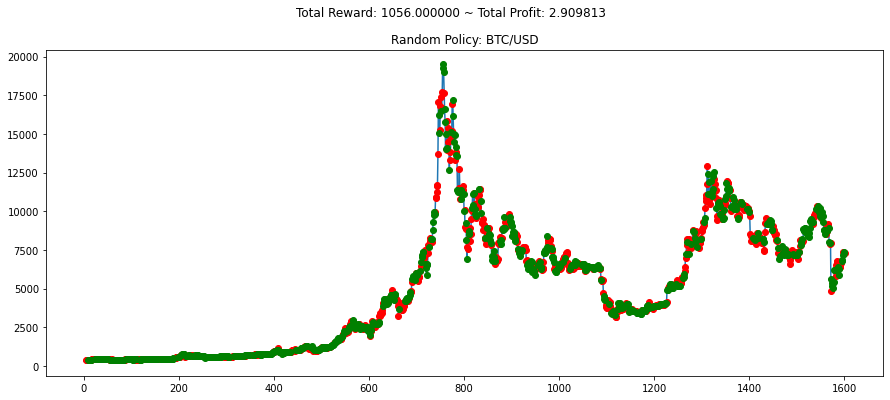

In [67]:
state = env_random.reset()
while True: 
    action = env_random.action_space.sample()
    n_state, reward, done, info = env_random.step(action)
    if done: 
        print("info", info)
        break


avg_reward = []

'''
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break 
'''

for x in range(100):
  state = env_random.reset()
  while True: 
    action = env_random.action_space.sample()
    n_state, reward, done, info = env_random.step(action)
    if done: 
        print("info", info)
        break
  avg_reward.append(info['total_reward'])

print("Average reward: ",(statistics.mean(avg_reward)/(upper_limit - lower_limit)))






plt.figure(figsize=(15,6))
plt.cla()
env_random.render_all()
plt.title("Random Policy: BTC/USD")
plt.show()

2.1.4. Create Custom Environments

In [ ]:
#from gym_anytrading.envs import StocksEnv

In [15]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 
                                     'Volume',
                                     'sma7',
                                     'sma40',
                                     'sma99',
                                     'bb_bbm',
                                     'bb_bbh',
                                     'bb_bbl',
                                     'psar',
                                     'MACD',
                                     'RSI',
                                     'OBV'
                                     ]].to_numpy()[start:end]
    return prices, signal_features

In [16]:
class MyCustomEnv(BinaryEnv):
    _process_data = add_signals
    


Reload the model

In [ ]:
#env2 = MyCustomEnv(df=df, window_size=5, frame_bound=(18000,39000))

model = DQN.load('/content/drive/MyDrive/Other Projects/EA_Robot_day_v6.0', env=env)


FileNotFoundError: ignored

#3. Build Environment and Train

In [52]:
#Original Environment
#env_maker = lambda: gym.make('forex-v0', df=df, frame_bound=(5,100), window_size=5)

#Custom Environment
env_maker = lambda: MyCustomEnv(df=df, window_size=5, frame_bound=(800,1200))
#env_maker = lambda: MyCustomEnv(df=df, window_size=5, frame_bound=(1000,1800))

env = DummyVecEnv([env_maker])

In [49]:
#model = A2C('MlpLstmPolicy', env, verbose=1) 
model = DQN(policy='MlpPolicy',env=env, verbose=1)
#model = ACER(MlpPolicy, env, verbose=1)

model.learn(total_timesteps=1000000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.6e+03  |
|    ep_rew_mean      | 516      |
|    exploration_rate | 0.97     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 33841    |
|    time_elapsed     | 0        |
|    total_timesteps  | 6384     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.6e+03  |
|    ep_rew_mean      | 519      |
|    exploration_rate | 0.939    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 34323    |
|    time_elapsed     | 0        |
|    total_timesteps  | 12768    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.6e+03  |
|    ep_rew_mean      | 515    

# Evaluation




In [50]:
#env = gym.make('forex-v0', df=df, frame_bound=(5,100), window_size=1)
env = MyCustomEnv(df=df, window_size=25, frame_bound=(lower_limit,upper_limit))


avg_reward = []

'''
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break 
'''

for x in range(100):
  obs = env.reset()
  while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break 
  avg_reward.append(info['total_reward'])

print("Average reward: ",statistics.mean(avg_reward)/(upper_limit-lower_limit))

info {'total_reward': 83.0, 'total_profit': 4.482588648238307, 'position': 1}
info {'total_reward': 63.0, 'total_profit': 8.988086963000642, 'position': 1}
info {'total_reward': 76.0, 'total_profit': 3.505493237569812, 'position': 0}
info {'total_reward': 78.0, 'total_profit': 24.108363292013625, 'position': 0}
info {'total_reward': 54.0, 'total_profit': 12.12902371782801, 'position': 0}
info {'total_reward': 68.0, 'total_profit': 13.617213041044764, 'position': 0}
info {'total_reward': 56.0, 'total_profit': 2.6418766537592533, 'position': 0}
info {'total_reward': 59.0, 'total_profit': 4.978251655480091, 'position': 1}
info {'total_reward': 66.0, 'total_profit': 11.020725619077858, 'position': 0}
info {'total_reward': 74.0, 'total_profit': 22.16287810899616, 'position': 0}
info {'total_reward': 65.0, 'total_profit': 11.792664231554536, 'position': 1}
info {'total_reward': 61.0, 'total_profit': 19.881947638998284, 'position': 1}
info {'total_reward': 74.0, 'total_profit': 2.574836852758

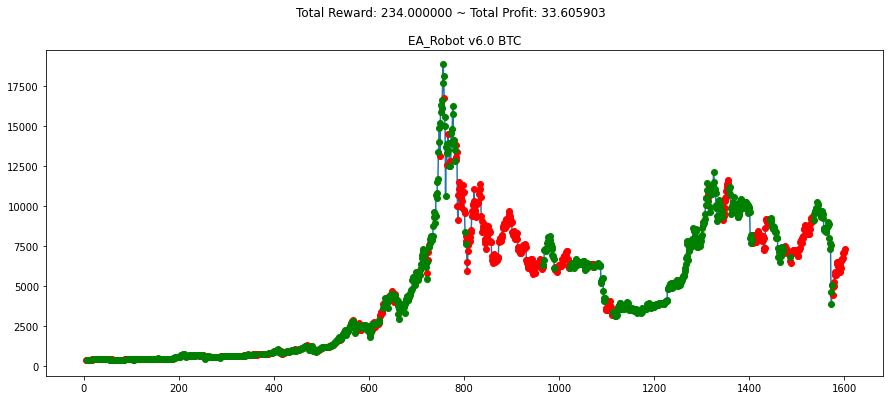

In [40]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.title("EA_Robot v6.0 BTC")
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Other Projects/EA_Robot_day_v5.0')

In [54]:
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
import tensorboard

In [56]:
save_path = os.path.join('Training', 'Saved Models')
log_path = os.path.join('Training', 'Logs')

In [70]:
stop_callback = StopTrainingOnRewardThreshold(reward_threshold=100000, verbose=1)
eval_callback = EvalCallback(env, 
                             callback_on_new_best=stop_callback, 
                             eval_freq=100, 
                             best_model_save_path=save_path, 
                             verbose=1)

In [71]:
model = DQN('MlpPolicy', env, verbose = 1, tensorboard_log=log_path)



Using cpu device


In [72]:
model.learn(total_timesteps=10000, callback=eval_callback)



ImportError: Trying to log data to tensorboard but tensorboard is not installed.